imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
"""============================================================================
Probabilistic canonical correlation analysis. For references in comments:

    A Probabilistic Interpretation of Canonical Correlation Analysis.
    Bach, Jordan (2006).

    The EM algorithm for mixtures of factor analyzers.
    Ghahramani, Hinton (1996).
============================================================================"""

import numpy as np

inv = np.linalg.inv


# -----------------------------------------------------------------------------

class PCCA:

    def __init__(self, n_components, n_iters, regularization=1.0):
        """Initialize probabilistic CCA model.
        """
        self.k = n_components
        self.n_iters = n_iters
        self.reg = regularization

    def fit(self, X1, X2):
        """Fit model via EM.
        """
        self._init_params(X1, X2)
        #np.linalg.cholesky(self.Psi)
        print('is psd')
        for _ in range(self.n_iters):
            self._em_step()
            #np.linalg.cholesky(self.Psi)

    def transform(self, X1, X2):
        """Embed data using fitted model.
        """
        X = np.hstack([X1, X2]).T
        Psi_inv = inv(self.Psi)
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        Z = M @ self.W.T @ Psi_inv @ X
        return Z.T

    def fit_transform(self, X1, X2):
        self.fit(X1, X2)
        return self.transform(X1, X2)

    def sample(self, n_samples=None):
        """Sample from the fitted model.
        """

        if n_samples is None:
          n_samples = self.n

        Psi_inv = inv(self.Psi)
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        Z_post_mean = M @ self.W.T @ Psi_inv @ self.X

        X_mean = self.W @ Z_post_mean
        X_samples = np.zeros((self.n, self.p))
        for i in range(self.n):
            X_samples[i] = np.random.multivariate_normal(X_mean[:, i], self.Psi)

        # Partition the columns => (X1, X2)
        X1_samples = X_samples[:, :self.p1]  # shape => (n, p1)
        X2_samples = X_samples[:, self.p1:]  # shape => (n, p2)

        return X1_samples, X2_samples

# -----------------------------------------------------------------------------

    def _em_step(self):
        Psi_inv = inv(self.Psi)
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        Z = M @ self.W.T @ Psi_inv @ self.X
        Ezz = Z @ Z.T + self.n * M

        # Update W explicitly
        W_new = (self.X @ Z.T) @ inv(Ezz)

        # Compute residuals explicitly
        X_recon = W_new @ Z
        residual = self.X - X_recon

        # Clearly separate Psi1 and Psi2
        residual1 = residual[:self.p1, :]
        residual2 = residual[self.p1:, :]

        Psi1_new = (residual1 @ residual1.T) / self.n + self.reg * np.eye(self.p1)
        Psi2_new = (residual2 @ residual2.T) / self.n + self.reg * np.eye(self.p2)

        # Combine Psi clearly
        self.Psi = np.block([
            [Psi1_new, np.zeros((self.p1, self.p2))],
            [np.zeros((self.p2, self.p1)), Psi2_new]
        ])

        # Update W
        self.W = (self.X @ Z.T) @ inv(Ezz)



    def _init_params(self, X1, X2):
        """Initialize parameters.
        """
        self.X1, self.X2 = X1, X2
        self.n, self.p1 = self.X1.shape
        _, self.p2 = self.X2.shape
        self.p = self.p1 + self.p2

        # Initialize sample covariances matrices.
        self.X = np.hstack([X1, X2]).T
        assert(self.X.shape == (self.p, self.n))
        self.Sigma1 = np.cov(self.X1.T)
        assert(self.Sigma1.shape == (self.p1, self.p1))
        self.Sigma2 = np.cov(self.X2.T)
        assert(self.Sigma2.shape == (self.p2, self.p2))

        # Initialize W.
        W1 = np.random.random((self.p1, self.k))
        W2 = np.random.random((self.p2, self.k))
        self.W = np.vstack([W1, W2])
        assert(self.W.shape == (self.p, self.k))

        # Initialize Psi.
        prior_var1 = 1
        prior_var2 = 1
        Psi1 = prior_var1 * np.eye(self.p1)
        Psi2 = prior_var2 * np.eye(self.p2)
        Psi = np.block([[Psi1, np.zeros((self.p1, self.p2))],
                        [np.zeros((self.p2, self.p1)), Psi2]])
        self.Psi = Psi

generate data:

In [ ]:
K1 = 311
K2 = 313
T = 557
t = np.linspace(0, 2, T)

#latent factors
d_s = 6 # shared latent dimension
d_1 = 2 # latent dimension for group 1
d_2 = 3 # latent dimension for group 2


rho = 1.0
l = 2.0
nu = 0.1

def rbf_kernel(t1, t2, rho=1.0, l=2.0):
    return rho * np.exp(-0.5 * ((t1[:, np.newaxis] - t2[np.newaxis, :]) / l)**2)

def gaussian_process_trajectories(t, n_trajectories, kernel_func, nu=0.1):
    K_tt = kernel_func(t, t)
    L = np.linalg.cholesky(K_tt + nu * np.eye(len(t)))
    trajectories = np.zeros((n_trajectories, len(t)))
    for k in range(n_trajectories):
        z = np.random.randn(len(t))
        trajectories[k] = L @ z
    return trajectories

Z_shared = gaussian_process_trajectories(t, d_s, rbf_kernel).T
Z_1 = gaussian_process_trajectories(t, d_1, rbf_kernel).T
Z_2 = gaussian_process_trajectories(t, d_2, rbf_kernel).T

A_s1 = np.random.randn(K1, d_s)
A_s2 = np.random.randn(K2, d_s)
A_1 = np.random.randn(K1, d_1)
A_2 = np.random.randn(K2, d_2)

X1 = np.zeros((K1, T))
X2 = np.zeros((K2, T))

for i in range(K1):
    shared_contrib = A_s1[i:i+1, :] @ Z_shared.T
    indep_contrib = A_1[i:i+1, :] @ Z_1.T
    X1[i] = (shared_contrib + indep_contrib).flatten()

for i in range(K2):
    shared_contrib = A_s2[i:i+1, :] @ Z_shared.T
    indep_contrib = A_2[i:i+1, :] @ Z_2.T
    X2[i] = (shared_contrib + indep_contrib).flatten()

X1 += np.random.normal(0, np.sqrt(nu), X1.shape)
X2 += np.random.normal(0, np.sqrt(nu), X2.shape)

In [ ]:
X1_pcca = X1.T
X2_pcca = X2.T

print(X1_pcca.shape)
print(X2_pcca.shape)

# 2) Fit PCCA with 'components=d_s' for the shared dimension
pcca = PCCA(d_s, 100)
pcca.fit(X1_pcca, X2_pcca)

# 3) True vs Learned Weights
true_weights = np.concatenate([A_s1, A_s2], axis=0)
learned_weights = pcca.W

# 4) Compare products W W^T
true_product    = true_weights @ true_weights.T
learned_product = learned_weights @ learned_weights.T

difference_frob = np.linalg.norm(true_product - learned_product, ord='fro')
print("Frobenius norm difference:", difference_frob)

# Normalized difference
true_norm    = np.linalg.norm(true_product,    ord='fro')
learned_norm = np.linalg.norm(learned_product, ord='fro')

normed_diff = np.linalg.norm(
    (true_product / true_norm) - (learned_product / learned_norm),
    ord='fro'
)
print("Normalized Frobenius difference:", normed_diff)

(557, 311)
(557, 313)
is psd
Frobenius norm difference: 7801.575994243609
Normalized Frobenius difference: 1.2091426142759203


is psd
latent_dims 1 done
is psd
latent_dims 2 done
is psd
latent_dims 3 done
is psd
latent_dims 4 done
is psd
latent_dims 5 done
is psd
latent_dims 6 done


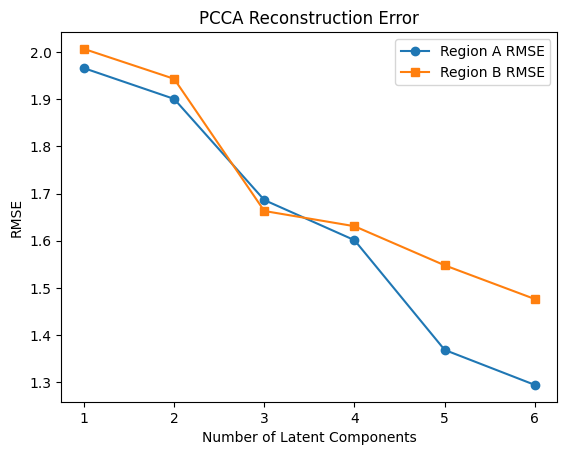

In [ ]:
from re import X
def pcca_rmse(X1, X2, components=2):
    # 1) Fit
    pcca = PCCA(components, 100)
    pcca.fit(X1_pcca, X2_pcca)

    # 2) Generate same # of samples as original
    n_samples = X1.shape[0]
    X1_gen, X2_gen = pcca.sample()

    # 3) RMSE
    num_samples = min(X1.shape[0], X2.shape[0])

    if X1.shape[0] != X2.shape[0]:
        X1, X2 = X1[:num_samples], X2[:num_samples]

    rmse1 = np.sqrt(np.mean((X1_gen - X1_pcca)**2))
    rmse2 = np.sqrt(np.mean((X2_gen - X2_pcca)**2))
    return rmse1, rmse2

# Suppose X1, X2 are (nSamples, nFeaturesA/B)
latent_dims = [1, 2, 3, 4, 5, 6]
rmseA, rmseB = [], []

for d in latent_dims:
    rA, rB = pcca_rmse(X1, X2, d)
    rmseA.append(rA)
    rmseB.append(rB)
    print(f"latent_dims {d} done")

plt.plot(latent_dims, rmseA, marker='o', label='Region A RMSE')
plt.plot(latent_dims, rmseB, marker='s', label='Region B RMSE')
plt.xlabel("Number of Latent Components")
plt.ylabel("RMSE")
plt.title("PCCA Reconstruction Error")
plt.legend()
plt.show()

In [ ]:
print("Mean of original data:", X1_pcca.mean(), X2_pcca.mean())
print("Std deviation of original data:", X1_pcca.std(), X2_pcca.std())

Mean of original data: -0.25467015108858393 0.1721414671685225
Std deviation of original data: 3.952385345702074 3.340064676183319


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pca = PCA(n_components=50)
X_scdg_pca = pca.fit_transform(X1_pcca)
X_scdg_reconstructed = pca.inverse_transform(X_scdg_pca)

pca_rmse = np.sqrt(mean_squared_error(X1_pcca, X_scdg_reconstructed))
print("PCA-only RMSE:", pca_rmse)

PCA-only RMSE: 0.25556819778359013


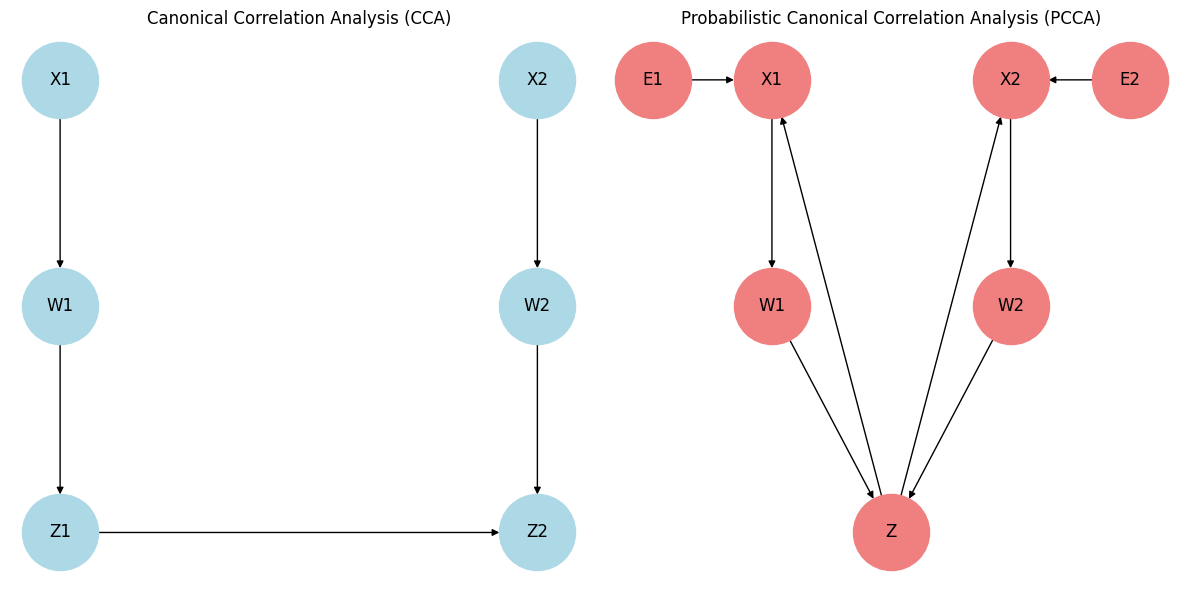

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def draw_cca(ax):
    """ Draws a conceptual diagram for Canonical Correlation Analysis (CCA) """
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from(["X1", "X2", "W1", "W2", "Z1", "Z2"])

    # Edges (mapping relationships)
    edges = [("X1", "W1"), ("X2", "W2"), ("W1", "Z1"), ("W2", "Z2"), ("Z1", "Z2")]
    G.add_edges_from(edges)

    # Node positions
    pos = {
        "X1": (0, 2), "X2": (2, 2),
        "W1": (0, 1), "W2": (2, 1),
        "Z1": (0, 0), "Z2": (2, 0)
    }

    # Draw graph
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, ax=ax)
    ax.set_title("Canonical Correlation Analysis (CCA)")

def draw_pcca(ax):
    """ Draws a conceptual diagram for Probabilistic Canonical Correlation Analysis (PCCA) """
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from(["X1", "X2", "W1", "W2", "Z", "E1", "E2"])

    # Edges (including noise terms)
    edges = [("X1", "W1"), ("X2", "W2"), ("W1", "Z"), ("W2", "Z"), ("Z", "X1"), ("Z", "X2"), ("E1", "X1"), ("E2", "X2")]
    G.add_edges_from(edges)

    # Node positions
    pos = {
        "X1": (-1, 1), "X2": (1, 1),
        "W1": (-1, 0), "W2": (1, 0),
        "Z": (0, -1),
        "E1": (-2, 1), "E2": (2, 1)
    }

    # Draw graph
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightcoral", font_size=12, ax=ax)
    ax.set_title("Probabilistic Canonical Correlation Analysis (PCCA)")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw diagrams
draw_cca(axes[0])
draw_pcca(axes[1])

plt.tight_layout()
plt.show()
